In [1]:
import torch
from pathlib import Path
import requests
import pickle
import gzip
import matplotlib
import numpy as np
from matplotlib import pyplot
import math

In [2]:
DATA_PATH = Path("data_alt")
PATH = DATA_PATH / "mnist"

In [3]:
PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [4]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

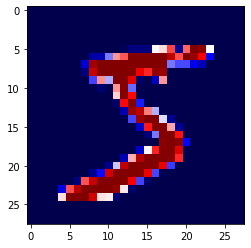

In [5]:
pyplot.imshow(x_train[0].reshape((28, 28)), cmap = 'seismic')

In [6]:
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [7]:
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [8]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [9]:
bs = 64
xb = x_train[0:bs]
preds = model(xb)
#preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.5515, -2.0431, -2.3339, -2.6590, -1.7946, -2.3924, -2.5395, -1.9613,
        -2.5574, -2.6479], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [10]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [11]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.4287, grad_fn=<NegBackward>)


In [12]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [13]:
print(accuracy(preds, yb))

tensor(0.0156)


In [14]:
print(loss_func(preds, yb).shape)

torch.Size([])


In [15]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 10  # how many epochs to train for

for epoch in range(epochs):
    print(epoch)
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

0
1
2
3
4
5
6
7
8
9


In [16]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0555, grad_fn=<NegBackward>) tensor(1.)


In [17]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [18]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))


tensor(0.0555, grad_fn=<NllLossBackward>) tensor(1.)


In [19]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, xb):
        return xb @ self.weights + self.bias

In [20]:
model = Mnist_Logistic()

In [21]:
print(loss_func(model(xb), yb))

tensor(2.2919, grad_fn=<NllLossBackward>)


In [22]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [23]:
print(loss_func(model(xb), yb))

tensor(0.0550, grad_fn=<NllLossBackward>)


In [24]:
# Refactor again

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

In [25]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.2678, grad_fn=<NllLossBackward>)


In [26]:
fit()

print(loss_func(model(xb), yb))

tensor(0.0552, grad_fn=<NllLossBackward>)


In [27]:
from torch import optim

In [28]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    print(epoch)
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3580, grad_fn=<NllLossBackward>)
0
1
2
3
4
5
6
7
8
9
tensor(0.0551, grad_fn=<NllLossBackward>)


In [29]:
from torch.utils.data import TensorDataset

In [30]:
train_ds = TensorDataset(x_train, y_train)

In [31]:
xb = x_train[start_i:end_i]
yb = y_train[start_i:end_i]
xb, yb = train_ds[i*bs : i*bs+bs]

In [32]:
xb, yb = train_ds[i*bs : i*bs+bs]

In [33]:
model, opt = get_model()

for epoch in range(epochs):
    print(epoch)
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

0
1
2
3
4
5
6
7
8
9
tensor(0.0552, grad_fn=<NllLossBackward>)


In [34]:
help(train_ds)

Help on TensorDataset in module torch.utils.data.dataset object:

class TensorDataset(Dataset)
 |  TensorDataset(*args, **kwds)
 |  
 |  Dataset wrapping tensors.
 |  
 |  Each sample will be retrieved by indexing tensors along the first dimension.
 |  
 |  Args:
 |      *tensors (Tensor): tensors that have the same size of the first dimension.
 |  
 |  Method resolution order:
 |      TensorDataset
 |      Dataset
 |      typing.Generic
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getitem__(self, index)
 |  
 |  __init__(self, *tensors: torch.Tensor) -> None
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __len__(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __annotations__ = {'tensors': typing.Tuple[torch.Tensor, ...]}
 |  
 |  __orig_bases__ = (torch.utils.data.dataset.Dataset[typing.Tuple[torch....
 |  
 |  __parameters__ = ()
 |  
 |  --

In [35]:
# Using DataLoader
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size = bs, num_workers = 2)

In [36]:
model, opt = get_model()

for epoch in range(epochs):
    print(epoch)
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

0
1
2
3
4
5
6
7
8
9
tensor(0.0555, grad_fn=<NllLossBackward>)


In [37]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [38]:
model, opt = get_model()

for epoch in range(epochs):
    print(epoch)
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0
0 tensor(0.3588)
1
1 tensor(0.3202)
2
2 tensor(0.2717)
3
3 tensor(0.2961)
4
4 tensor(0.2767)
5
5 tensor(0.3522)
6
6 tensor(0.2676)
7
7 tensor(0.2922)
8
8 tensor(0.2765)
9
9 tensor(0.2691)


In [39]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [40]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [41]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [42]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3074694025397301
1 0.2996636783242226
2 0.2829707953214645
3 0.3506061047434807
4 0.27505996741056443
5 0.27586731004714965
6 0.3138345586538315
7 0.27726793846488
8 0.274765381526947
9 0.2810439167618752


In [43]:
# CNN
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

In [44]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.36925131170749664
1 0.23147286533117295
2 0.18116162124872207
3 0.16373501567840576
4 0.19436325995922088
5 0.1370927269101143
6 0.1392441325068474
7 0.11812602360546588
8 0.1204397741317749
9 0.11342527024745941


In [45]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [46]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [47]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [48]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)


0 0.3531205452263355
1 0.22795068334639074
2 0.22287103703022004
3 0.19055086073279381
4 0.17168541347980498
5 0.1596343122214079
6 0.14258123113960028
7 0.14867576576471328
8 0.14785299591720105
9 0.13324177740216256


In [51]:
# Using GPU
print(torch.cuda.is_available())


True


In [52]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [53]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [54]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)


0 0.1303500663250685
1 0.12369029915034771
2 0.13063027766346932
3 0.13412892690002917
4 0.12622670190483332
5 0.12327847203910351
6 0.14302172850891948
7 0.12058610234111547
8 0.12338311394006014
9 0.12314812543205916
